***Lunar dataset***

In [1]:
import pandas as pd
cat_directory = 'E:\\seismic wave detection\\space_apps_2024_seismic_detection\\data\\lunar\\training\\catalogs\\'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

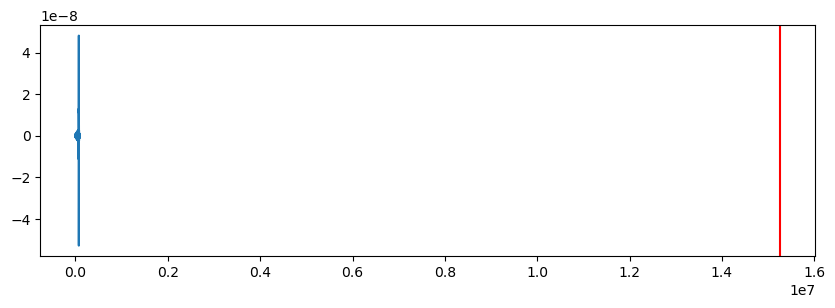

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

row = cat.iloc[6]  # Example: selecting the 7th event
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
test_filename = row['filename']

data_directory = 'E:\\seismic wave detection\\space_apps_2024_seismic_detection\\data\\lunar\\training\\data\\S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

# Plotting
csv_times = np.array(data_cat['time_rel(sec)'])
csv_data = np.array(data_cat['velocity(m/s)'])
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(csv_times, csv_data)
ax.axvline(x=arrival_time.timestamp(), color='red', label='Arrival Time')
plt.show()


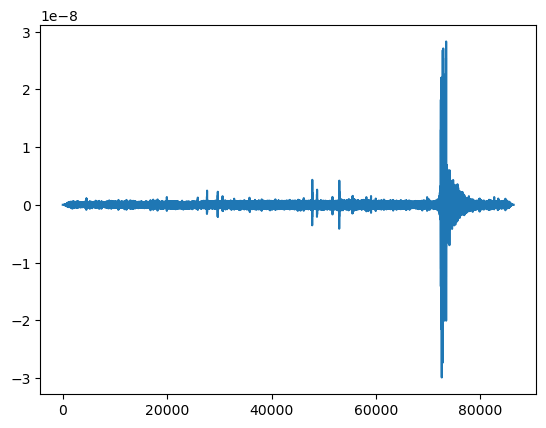

In [5]:
from obspy.signal.filter import bandpass

st_filt = bandpass(data=csv_data, freqmin=0.01, freqmax=0.5, df=6.625)  # Apply filter
plt.plot(csv_times, st_filt)
plt.show()


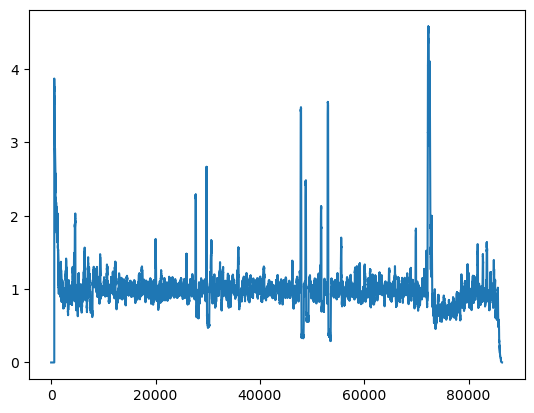

In [6]:
from obspy.signal.trigger import classic_sta_lta

sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = 6.625  # Sampling rate

# Run STA/LTA
cft = classic_sta_lta(csv_data, int(sta_len * df), int(lta_len * df))

# Plot
plt.plot(csv_times, cft)
plt.show()

In [7]:
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


Steps 

1.Catelog data contains the info for the seismic event occurance 

2.From the catelog use tranning data and preprocess it to feed it to the model

In [9]:
# Check for missing values
print(data_cat.isnull().sum())

# Remove rows with missing values
data_cleaned = data_cat.dropna()


time_abs(%Y-%m-%dT%H:%M:%S.%f)    0
time_rel(sec)                     0
velocity(m/s)                     0
dtype: int64


In [10]:
data_cleaned['velocity(m/s)'] = np.clip(data_cleaned['velocity(m/s)'], -1, 1)


In [11]:
data_cleaned

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


In [12]:
from scipy.signal import resample

# Resample to a fixed number of points (e.g., 1000 points)
num_samples = 1000
csv_data_resampled = resample(csv_data, num_samples)
csv_times_resampled = np.linspace(min(csv_times), max(csv_times), num_samples)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
csv_data_normalized = scaler.fit_transform(csv_data.reshape(-1, 1)).flatten()


In [16]:
csv_data_normalized

array([-7.79331861e-05, -7.80530315e-05, -7.80937576e-05, ...,
       -7.75304222e-05, -7.75693989e-05, -7.76653185e-05])

In [17]:
from obspy.signal.filter import bandpass

# Apply bandpass filter between 0.01 Hz and 0.5 Hz
minfreq = 0.01
maxfreq = 0.5
csv_data_filtered = bandpass(csv_data, freqmin=minfreq, freqmax=maxfreq, df=6.625)


In [18]:
window_size = 10  # Adjust window size based on data needs
csv_data_smoothed = np.convolve(csv_data_filtered, np.ones(window_size)/window_size, mode='valid')


In [19]:
from scipy.signal import detrend

csv_data_detrended = detrend(csv_data_filtered)


In [20]:
amplitude = np.max(np.abs(csv_data_detrended))  # Max amplitude
energy = np.sum(np.square(csv_data_detrended))  # Energy of the signal


In [21]:
window_size = 1000  # Adjust based on your data
num_windows = len(csv_data_detrended) // window_size

for i in range(num_windows):
    window_data = csv_data_detrended[i*window_size : (i+1)*window_size]
    # Process window_data here


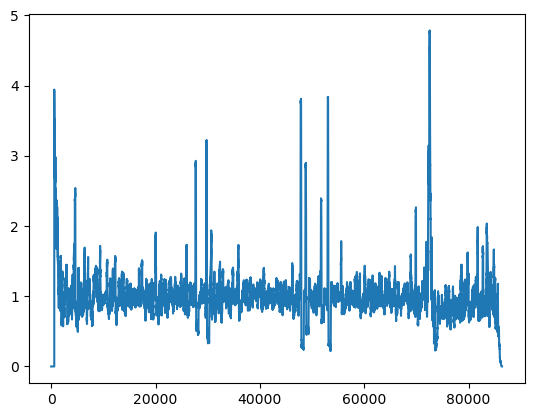

In [22]:
from obspy.signal.trigger import classic_sta_lta

# STA/LTA parameters
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = 6.625  # Sampling rate

# Run STA/LTA
cft = classic_sta_lta(csv_data_detrended, int(sta_len * df), int(lta_len * df))

# Plot the characteristic function to identify seismic events
plt.plot(csv_times, cft)
plt.show()


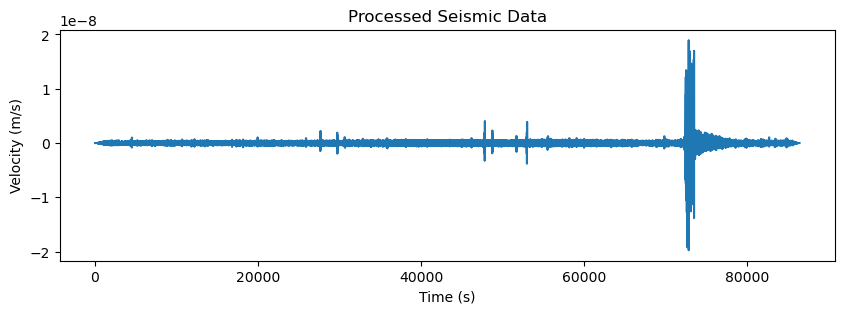

In [23]:
plt.figure(figsize=(10, 3))
plt.plot(csv_times[:len(csv_data_smoothed)], csv_data_smoothed)
plt.title('Processed Seismic Data')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()


In [24]:
csv_data_detrended

array([-1.43184543e-18, -9.49430431e-18, -3.66682323e-17, ...,
        4.98882577e-15,  4.78945679e-15,  4.55773185e-15])